In [1]:
import librosa
import os # библиотека для работы с файлами
import matplotlib.pyplot as plt
import librosa.display as ld
import numpy as np
import pandas as pd
import random

In [43]:
n_fft = 8195
sr = 22050
hop_length = n_fft // 2

def zero_crossing_rate(signal):  # Средняя частота пересечения нуля
    zrate = librosa.feature.zero_crossing_rate(signal)

    return np.mean(zrate), np.var(zrate)

def spectral_centroid(signal):  # Спектральный центроид
    cent = librosa.feature.spectral_centroid(y=signal, sr=sr)

    return np.mean(cent), np.var(cent)

def spectral_rolloff(signal):  # Спектральный спад
    rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr)

    return np.mean(rolloff), np.var(rolloff)

def spectral_flatness(signal):  # Спектральная плоскость
    flatness = librosa.feature.spectral_flatness(y=signal)

    return np.mean(flatness), np.var(flatness)

def chroma_features(signal):  # Выдающиеся тона через набор частотных полос
    chroma = librosa.feature.chroma_stft(y=signal, sr=sr)

    return np.mean(chroma), np.var(chroma)

def bandwidth(signal):  # Полоса пропускания
    bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)

    return np.mean(bandwidth), np.var(bandwidth)

def tempo_estimate(signal):  # Оценка темпа
    tempo = librosa.beat.tempo(y=signal, sr=sr)

    return np.mean(tempo), np.var(tempo)



In [54]:
segment_duration = 20  # Длительность каждого сегмента в секундах
segment_samples = segment_duration * sr  # Количество отсчетов в каждом сегменте

def segment_audio(signal, sr, segment_duration, overlap):
    # Разбиваем аудиозапись на сегменты по segment_duration секунд с перекрытием overlap
    segments = []
    start = 0
    while start + segment_duration <= len(signal) / sr:
        segment = signal[int(start * sr): int((start + segment_duration) * sr)]
        # Если сегмент короче ожидаемой длительности, дополним его нулями
        if len(segment) < segment_duration * sr:
            segment = np.concatenate([segment, np.zeros(segment_duration * sr - len(segment))])
        segments.append(segment)
        start += overlap
    return segments

def extract_features(signal):
    features = {}
    features['zero_crossing_mean'], features['zero_crossing_var'] = zero_crossing_rate(signal)  # Средняя частота пересечения нуля
    features['spectral_cent_mean'], features['spectral_cent_var'] = spectral_centroid(signal)  # Спектральный центроид
    features['spectral_rolloff_mean'], features['spectral_rolloff_var'] = spectral_rolloff(signal)  # Спектральный спад
    features['spectral_flatness_mean'], features['spectral_flatness_var'] = spectral_flatness(signal)  # Спектральная плоскость
    features['chroma_mean'], features['chroma_var'] = chroma_features(signal)  # Выдающиеся тона через набор частотных полос
    features['bandwidth_mean'], features['bandwidth_var'] = bandwidth(signal)  # Полоса пропускания
    features['tempo_mean'], features['tempo_var'] = tempo_estimate(signal)  # Оценка темпа
    return features

csv_path = 'new_songs_features.csv'

try:
    with open(csv_path, 'w') as file:
        file.truncate(0)
    print(f"Файл '{csv_path}' очищен успешно.")
except Exception as e:
    print(f"Ошибка при очистке файла '{csv_path}': {e}")

# Путь к папке с аудиокомпозициями
songs_dir = 'songs/'

# Список имен файлов в папке songs
file_names = os.listdir(songs_dir)

# Создание пустого списка для хранения словарей признаков
segments_data = []

# Добавление признаков в DataFrame для каждого сегмента каждой композиции

for filename in file_names:
    file_path = os.path.join(songs_dir, filename)
    signal, sr = librosa.load(file_path, sr=sr)
    segments = segment_audio(signal, sr, segment_duration, segment_duration / 2)  # Изменение с перекрытием
    for i, segment in enumerate(segments):
        # Обрезаем тишину в начале и в конце сегмента
        segment, _ = librosa.effects.trim(segment) # эта строка убирается, если тишину необходимо оставить
        features = extract_features(segment)
        segment_data = {'filename': f"{filename[:-4]}_{i+1}", **features}
        segments_data.append(segment_data)

# Создание DataFrame из списка словарей
df = pd.DataFrame(segments_data)

# Вывод DataFrame
print(df)
df.to_csv(csv_path, index=False)

Файл 'new_songs_features.csv' очищен успешно.


C:\Users\ccoo0\AppData\Local\Temp\ipykernel_6836\3387392438.py:36: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sr)


                                        filename  zero_crossing_mean  \
0    7 Seconds -- Youssou N'Dour, Neneh Cherry_1            0.078791   
1    7 Seconds -- Youssou N'Dour, Neneh Cherry_2            0.058010   
2    7 Seconds -- Youssou N'Dour, Neneh Cherry_3            0.069551   
3    7 Seconds -- Youssou N'Dour, Neneh Cherry_4            0.072787   
4    7 Seconds -- Youssou N'Dour, Neneh Cherry_5            0.072796   
..                                           ...                 ...   
306             Bag Raiders -- Shooting stars_17            0.139179   
307             Bag Raiders -- Shooting stars_18            0.138928   
308             Bag Raiders -- Shooting stars_19            0.139011   
309             Bag Raiders -- Shooting stars_20            0.138781   
310             Bag Raiders -- Shooting stars_21            0.146122   

     zero_crossing_var  spectral_cent_mean  spectral_cent_var  \
0             0.007335         2167.678790      934130.593848   
1    

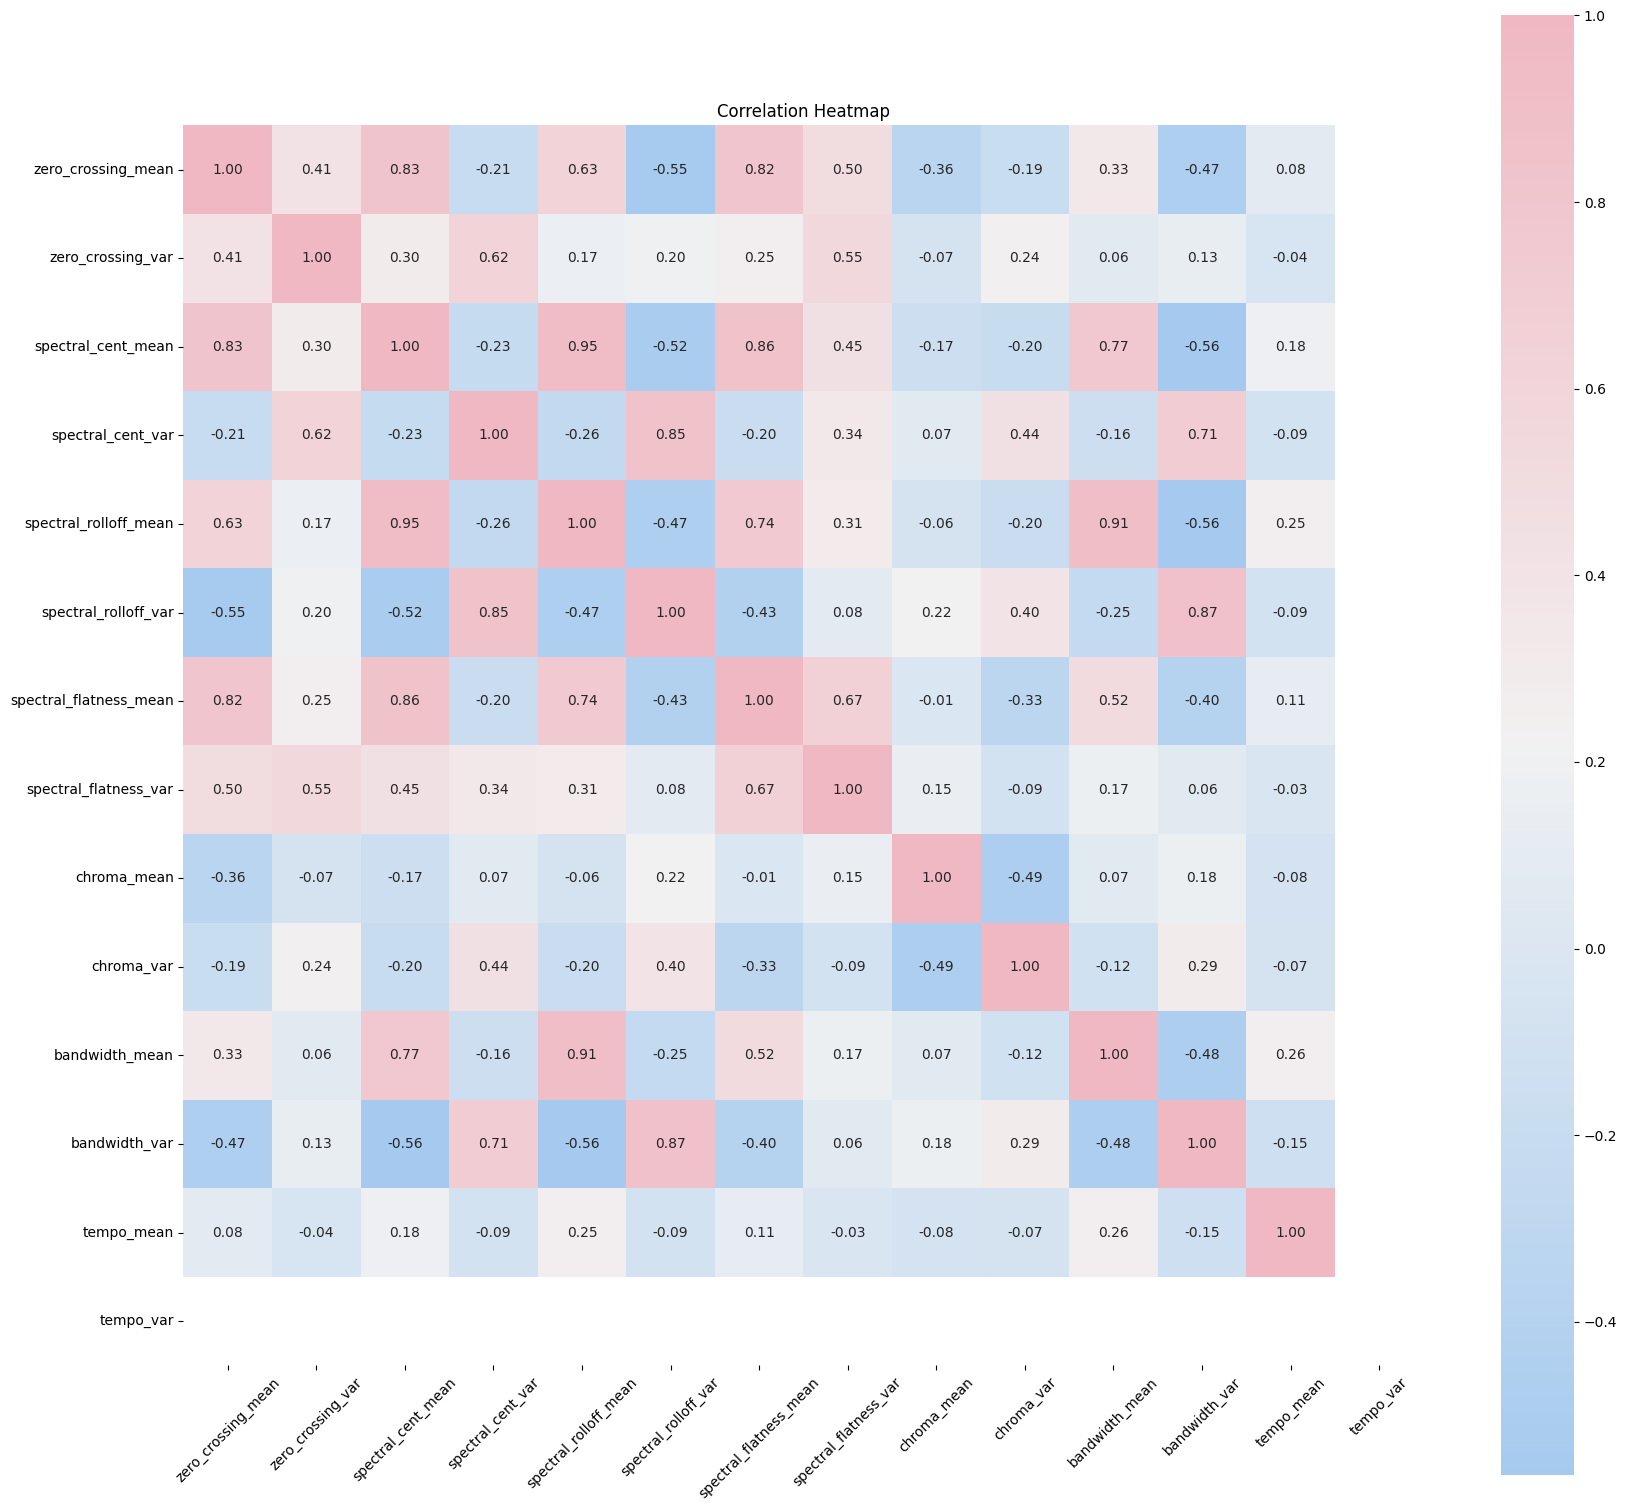

In [33]:
import seaborn as sns

# Удаляем столбец 'filename' из DataFrame
df_without_filename = df.drop(columns=['filename'])

fig, ax = plt.subplots(figsize=(20, 20))
plt.title('Correlation Heatmap')
cmap = sns.diverging_palette(240, 0, s=70, l=80, as_cmap=True)
ax_sns = sns.heatmap(ax=ax, data=df_without_filename.corr(), cmap=cmap, square=True, annot=True, fmt='.2f', linecolor='white')
ax_sns.set_xticklabels(ax_sns.get_xticklabels(), rotation=45)
ax_sns.set_yticklabels(ax_sns.get_yticklabels(), rotation=0)
plt.subplots_adjust(bottom=0.15)
plt.show()

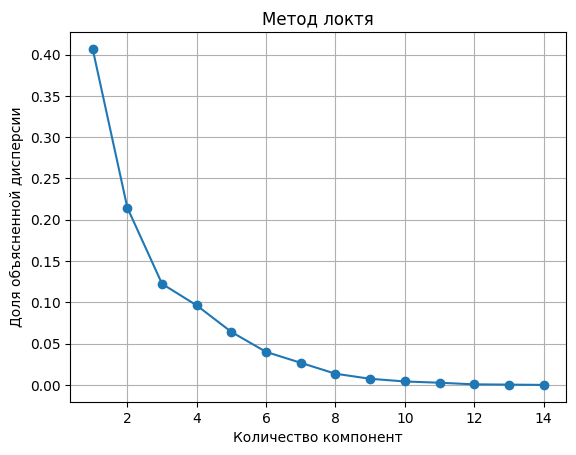

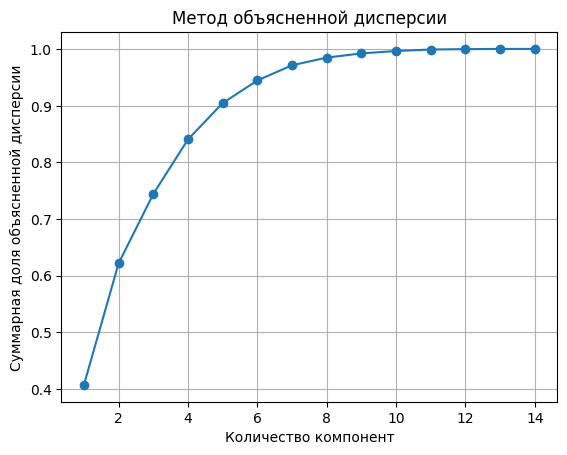

In [38]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Инициализируем PCA с максимальным числом компонент
pca = PCA(n_components=len(X.columns))

# Стандартизируем данные
X_scaled = StandardScaler().fit_transform(X)

# Выполняем PCA
pca.fit(X_scaled)

# Метод локтя
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Метод локтя')
plt.grid(True)
plt.show()

# Метод объясненной дисперсии
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Суммарная доля объясненной дисперсии')
plt.title('Метод объясненной дисперсии')
plt.grid(True)
plt.show()


In [40]:
# Отбросим столбец 'filename' перед стандартизацией
X = df.drop(columns=['filename'])

# Стандартизируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применяем PCA для уменьшения размерности до 4 компонент
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Создаем DataFrame с уменьшенной размерностью, используя только компоненты PCA
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Добавляем столбец с названиями композиций
df_pca['filename'] = df['filename']

# Выводим DataFrame с уменьшенной размерностью
print(df_pca)


# Добавляем столбец с названиями композиций
df_pca['filename'] = df['filename']

# Выводим DataFrame с уменьшенной размерностью
print(df_pca)


          PC1       PC2       PC3       PC4  \
0    2.036818  0.989497 -0.919447 -1.271856   
1    2.247223 -0.036477 -0.847212 -2.080995   
2    1.414195 -0.107600 -0.961442 -2.182591   
3    1.432801  0.255501 -1.350748 -2.417889   
4    1.540419  0.012087 -1.277298 -2.267330   
..        ...       ...       ...       ...   
204 -1.562420  1.236151 -0.310102  0.573050   
205 -2.901658  1.148932  0.155836  0.414511   
206 -2.979264  0.744405  0.244130  0.407486   
207 -3.089127  0.845834  0.450639  0.492621   
208 -3.199193 -0.553434 -0.640876 -0.148142   

                                        filename  
0    7 Seconds -- Youssou N'Dour, Neneh Cherry_1  
1    7 Seconds -- Youssou N'Dour, Neneh Cherry_2  
2    7 Seconds -- Youssou N'Dour, Neneh Cherry_3  
3    7 Seconds -- Youssou N'Dour, Neneh Cherry_4  
4    7 Seconds -- Youssou N'Dour, Neneh Cherry_5  
..                                           ...  
204             Bag Raiders -- Shooting stars_10  
205             Bag Raiders

In [55]:
filename_new = 'test_data/Bad Romance.wav'
signal = librosa.load(filename_new, sr=22050, duration=segment_duration)[0] #, duration=20

zero_crossing_mean, zero_crossing_var = zero_crossing_rate(signal)
spectral_cent_mean, spectral_cent_var = spectral_centroid(signal)
spectral_rolloff_mean, spectral_rolloff_var = spectral_rolloff(signal)
spectral_flatness_mean, spectral_flatness_var = spectral_flatness(signal)
chroma_mean, chroma_var = chroma_features(signal)
bandwidth_mean, bandwidth_var = bandwidth(signal)
tempo_mean, tempo_var = tempo_estimate(signal)  # Оценка темпа

new_features = [zero_crossing_mean, zero_crossing_var, spectral_cent_mean, spectral_cent_var, spectral_rolloff_mean, spectral_rolloff_var, spectral_flatness_mean, spectral_flatness_var, chroma_mean, chroma_var, bandwidth_mean, bandwidth_var, tempo_mean, tempo_var]
new_features = np.array(new_features).reshape(1, -1)


print(new_features)

[[1.24149756e-01 1.47413525e-03 2.90997339e+03 2.17335873e+05
  6.37478987e+03 8.47835156e+05 3.66433635e-02 6.48252480e-03
  2.83666849e-01 9.14323404e-02 2.76715416e+03 7.41124465e+04
  1.17453835e+02 0.00000000e+00]]


C:\Users\ccoo0\AppData\Local\Temp\ipykernel_6836\3387392438.py:36: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(y=signal, sr=sr)


In [56]:
from sklearn.metrics.pairwise import euclidean_distances

# Загрузка данных из файла
df = pd.read_csv('new_songs_features.csv')

# Вычисление расстояний между новыми признаками и признаками в DataFrame
distances = euclidean_distances(new_features, df.drop(columns=['filename']))

# Нахождение индекса наименее удаленной композиции
closest_index = np.argmin(distances)

# Получение названия наиболее похожей композиции
closest_song = df.loc[closest_index, 'filename']

print(f"Наиболее похожая композиция: {closest_song}")

# Нахождение индексов 5 наиболее похожих композиций
closest_indices = np.argsort(distances)[0][:5]

# Вывод 5 наиболее похожих композиций и их расстояний
print("5 наиболее похожих композиций:")
for i, idx in enumerate(closest_indices, 1):
    closest_song = df.loc[idx, 'filename']
    distance = distances[0, idx]
    print(f"{i}. {closest_song}, Расстояние: {distance}")


Наиболее похожая композиция: All The Things She Said_9
5 наиболее похожих композиций:
1. All The Things She Said_9, Расстояние: 25395.67338904276
2. Bad Romance_19, Расстояние: 50124.98322548085
3. Bad Romance_12, Расстояние: 53133.025006930344
4. ABBA -- The Winner Takes It All_19, Расстояние: 60960.27597260071
5. Bad Romance_28, Расстояние: 63934.34011610018


In [53]:
# Создайте словарь для хранения сумм расстояний по композициям
sum_distances = {}

# Проход по каждой строке DataFrame X (признаки каждого фрагмента)
for index, row in df.iterrows():
    # Преобразуйте индекс в строку и получите название композиции из индекса строки
    composition_name = row['filename'].split('_')[0]
    
    # Если композиция еще не добавлена в словарь, добавьте ее
    if composition_name not in sum_distances:
        sum_distances[composition_name] = 0
    
    # Вычислите расстояние между текущим фрагментом и новой композицией
    distance = euclidean_distances(new_features, row[1:].values.reshape(1, -1))
    
    # Добавьте расстояние к сумме расстояний для данной композиции
    sum_distances[composition_name] += distance

# Преобразуйте словарь в DataFrame для удобства обработки
sum_distances_df = pd.DataFrame(list(sum_distances.items()), columns=['Composition', 'Sum Distance'])

# Преобразуйте столбец 'Sum Distance' в числовой формат
sum_distances_df['Sum Distance'] = sum_distances_df['Sum Distance'].astype(float)

# Найдите наиболее похожие композиции на основе сумм расстояний
closest_compositions = sum_distances_df.nsmallest(11, 'Sum Distance')

# Выведите результаты
print("Наиболее похожие композиции:")
for index, row in closest_compositions.iterrows():
    print(f"{row['Composition']}, Сумма расстояний: {row['Sum Distance']}")


Наиболее похожие композиции:
a-ha -- Take On Me, Сумма расстояний: 27276042.409910608
Bad Bad Boys, Сумма расстояний: 29512866.832595028
ABBA -- Money, Money, Money, Сумма расстояний: 30085675.532132566
Bad Romance, Сумма расстояний: 33175420.637563474
Bag Raiders -- Shooting stars, Сумма расстояний: 36129139.68815504
B.o.B, Hayley Williams of Paramore -- Airplanes (feat. Hayley Williams of Paramore), Сумма расстояний: 40692487.7970621
ABBA -- The Winner Takes It All, Сумма расстояний: 45876122.357666895
All The Things She Said, Сумма расстояний: 57567151.597982794
B.o.B, Jessie J -- Price Tag, Сумма расстояний: 74096670.97180362
Apologize, Сумма расстояний: 78293395.57485041
Animals — Martin Garrix, Сумма расстояний: 122946730.85181688
